## <center> Projet 3 - Parcours Machine Learning :<br/>Consommation électrique de la ville de Seattle </center>

<p style="text-align:center;">Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.</p>

<center><img src="image/logo_seattle.png" alt="logo_seattle" width="500" /></center>

##### Les données

Les données de consommation sont [à télécharger ici](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv).

##### Problématique de la ville de Seattle

<p style="text-align:justify;">Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.</p>

##### Votre mission

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

>L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 
>
>Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
>
>Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.
>

#### Let's go :

In [1]:
###################################################################################################
####################                       Import librairies                    ###################
###################################################################################################
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os.path
from os import path
from math import *
from numpy import isnan
from global_functions_variables import *
import altair as alt
from vega_datasets import data
import folium
import folium.plugins
import statistics as stats
from haversine import haversine

#### Les fichiers CSV :

<p>Les relevés énergétiques sont stockés dans 2 fichiers csv :</p>

- Les relevés de 2015
- Les relevés de 2016

<p>On remarque rapidement que les deux bases de données n'ont pas le même nombre de colonnes.
Une analyse des différences montre les faits suivants :</p>

1. Les variables de localisation du fichier de 2016 :<br>
    *Latitude*,<br>
    *Longitude*,<br>
    *City*,<br>
    *Address*,<br>
    *zipCode*,<br>
    *State*<br> sont **compressées** dans une seule variable *Location* dans le fichier de 2015

2. Les variables du fichier 2015 :<br> 
     *OtherFuelUse(kBtu)*,<br> 
     *2010 Census Tracts*,<br> 
     *Seattle Police Department Micro Community Policing Plan Areas*,<br> 
     *City Council Districts*,<br> 
     *SPD Beats*,<br>
     *Zip Codes*,<br>non présentes en 2016, sont **vides, faussées ou sans rapport avec la consommation d'énergie**
    
3. Les dernières différences de variables représentent **les mêmes données sous la même métrique** mais **sous un autre nom**.

<p>Pour rassembler ces deux bases de données il faut donc :</p>

1. Décompresser la variable *Location* de 2015 et sauvegarder ses valeurs dans de nouvelles colonnes de même noms que la version 2016

2. Retirer les colonnes non pertinentes du DataFrame de 2015

3. Renommer les variables restantes pour s'adapter aux variables de 2016

Une fois ces étapes effectuées, les deux DataFrames pourront être combinés afin de traiter les données de 2015 et de 2016 simultanément.

In [4]:
###################################################################################################
####################          Load and merge CSV files from 2015 and 2016       ###################
###################################################################################################

#read csv file and stock it in dataframe
data_2015 = pd.read_csv(r'Data/2015-building-energy-benchmarking.csv',
                        sep=',', encoding='utf-8', na_values='')
data_2016 = pd.read_csv(r'Data/2016-building-energy-benchmarking.csv',
                        sep=',', encoding='utf-8', na_values='')
print(f"The 2016 CSV file had {data_2016.shape[1]}\
 fields and the 2015 CSV file had {data_2015.shape[1]} fields")
    
# 1.Re-Organize location variables - Dezip latitude, longitude ect..
decompressed = {'Latitude': [],
                'Longitude' : [],
                'City' : [],
                'Address' : [],
                'ZipCode' : [],
                'State': []}

for loc in data_2015['Location']:
    loc_dict = eval(loc)
    address_dict = eval(loc_dict['human_address'])
    decompressed['Latitude'].append(round(float(loc_dict['latitude']),5))
    decompressed['Longitude'].append(round(float(loc_dict['longitude']),5))
    decompressed['City'].append(address_dict['city'])
    decompressed['Address'].append(address_dict['address'])
    decompressed['ZipCode'].append(address_dict['zip'])
    decompressed['State'].append(address_dict['state'])
data_2015 = pd.concat([data_2015.drop('Location',axis=1), pd.DataFrame(decompressed)],axis=1)

# 2. Remove variables only present in 2015 AND empty, irrelevant or wrong :
data_2015.drop(["OtherFuelUse(kBtu)",'2010 Census Tracts',
                'Seattle Police Department Micro Community Policing Plan Areas',
                'City Council Districts',"SPD Beats", 'Zip Codes'], axis=1, inplace=True)

# For "GHGEmissions(MetricTonsCO2e) --> TotalGHGEmissions 
#we have checked beforehand that 2015 and 2016 dataset use the same metrics !

# 3. Rename 2015 variable to their 2016 names
data_2015.rename(columns={"Comment" : "Comments",
                          "GHGEmissions(MetricTonsCO2e)" : "TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)" : "GHGEmissionsIntensity"
                         },inplace=True)

# Finally, combine both into a 2015-2016 dataframe
if len(set(data_2016.columns).symmetric_difference(set(data_2015.columns))) == 0 :
    print("Both datasets have the same number of columns, it could be concatenate now")
    df = pd.concat([data_2015, data_2016], axis=0)
else:
    print("Something gone wrong")

df.reset_index(drop=True, inplace=True)
print(f"The shape of 2015-2016 dataset is {df.shape}")

The 2016 CSV file had 46 fields and the 2015 CSV file had 47 fields
Both datasets have the same number of columns, it could be concatenate now
The shape of 2015-2016 dataset is (6716, 46)



---

#### Nettoyage des données :

##### Supprimer les doublons:

<p>La conséquence d'avoir mergé deux dataset d'année différente est que nos données sont parfois en double. Notre modélisation n'a pas de dimension temporelle, conserver ces doublons risque d'induire des erreurs dans notre modèle</p>

 1. Les individus uniques sont séparés des individus doublés
 
 2. Les addresses et localisation des doublons sont vérifiées
 
 3. Quelques graphiques
 
 4. Les valeurs conservées entre les doublons doit être pertinente
 
 5. Le dataset est reformé
 
 6. Dernière vérification qu'il n'existe plus de doublons


In [5]:
###################################################################################################
####################                Pick and remove duplicates                  ###################
###################################################################################################

# 1.Divise dataframe between duplicate from 2015, 2016 and unique rows

# Create dataframe with uniques rows
unique_df = df.loc[~df.duplicated('OSEBuildingID', keep=False), :]
print(f"There is {unique_df.shape[0]} unique building from dataset")

# Create two parallels dataframes with only duplicates
df_temp = df.loc[df.duplicated('OSEBuildingID', keep=False), :]
#Very important to sort first and then reset index : combine depends on it
df15 = df_temp.loc[df_temp['DataYear']==2015, :].sort_values(by='OSEBuildingID')
df16 = df_temp.loc[df_temp['DataYear']==2016, :].sort_values(by='OSEBuildingID')
print(f"There is {df_temp.shape[0]} duplicated buildings from dataset, {df15.shape[0]} from 2015`\
      \n and {df15.shape[0]} from 2016")

df15 = df15.reset_index(drop=True)
df16 = df16.reset_index(drop=True)

del df_temp

# 2. Check if they're really duplicate 

#Some latitude/longitude are really far away and address don't match investigate on this

# 3. Show difference between 2015 and 2016 with some graphics

#TODO

# 4.Combine 2015 and 2016 duplicates for maximise informations

#Replace any NaN with the equivalent value from another year
df15.fillna(df16, inplace=True)
df16.fillna(df15, inplace=True)

#Replace zeros and negatives values
replace_neg = lambda s1, s2: s2 if s1 < 0 else s1
for var in ['NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore','PropertyGFATotal',
            'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA', 
            'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
            'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']:
    df16[var] = df16[var].combine(df15[var], replace_neg)
    df15[var] = df15[var].combine(df16[var], replace_neg)

#Replace the Other value in Property Type
replace_other = lambda s1, s2: s2 if s1 == 'Other' else s1
for var in ['PrimaryPropertyType', 'LargestPropertyUseType',
            'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    df16[var] = df16[var].combine(df15[var], replace_other)
    
#Check GFA total sum and replace it if needed
replace_GFA = lambda s1, s2: s2 if (s1[0]!=s1[1]+s1[2] and s2[0]==s2[1]+s2[2]) else s1
var = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)']
df16[var] = df16[var].T.combine(df15[var].T, replace_GFA).T

#Get mean values
replace_mean = lambda s1, s2: round((s1+s2)/2,5)
for var in ['ENERGYSTARScore','SiteEnergyUse(kBtu)',
            'TotalGHGEmissions', 'Latitude', 'Longitude']:
    df16[var] = df16[var].combine(df15[var], replace_mean)


# 5. Resize dataframe in a duplicate-free version
    
#Concatenate duplicates from 2016 because it's most recent
df = pd.concat([unique_df, df16]).sort_values(by='OSEBuildingID').reset_index(drop=True)

print(f"The final shape of 2015-2016 dataset is {df.shape}")
# 6. Check if there is no duplicate anymore

#TODO

There is 148 unique building from dataset
There is 6568 duplicated buildings from dataset, 3284 from 2015`      
 and 3284 from 2016
The final shape of 2015-2016 dataset is (3432, 46)


#### Nettoyage des données :

##### Supprimer les bâtiments résidentiels:

<p>Dans l'intitulé du projet il est dit :</p>

>Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions **des bâtiments non destinés à l’habitation.**

<p>Les bâtiments résidentiels doivent être supprimer de notre DataFrame. Les valeurs de *BuildingType* et *PrimaryPropertyType* sont étudiées, il s'y trouve trois valeurs représentant des bâtiment résidentiels :</p>

 - Multifamily MR (5-9)
 - Multifamily LR (1-4)
 - Multifamily HR (10+)
 - Low-Rise Multifamily
 
<p>1. Tout individus ayant ces valeurs dans le champs *BuildingType* est donc retirer de notre DataFrame</p>

<p>2. On retire également les individus n'ayant pas renseigné leur consomation d'énergie ou leur émission de gaz.</p>

In [6]:
###################################################################################################
####################                   Réduction des individus                  ###################
###################################################################################################

# 1.Removing residentials buildings from dataset
resi_buildings = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']
print(f"The final shape of 2015-2016 dataset is {df.shape}")
df = df.loc[~df['BuildingType'].isin(resi_buildings)]
print(f"The final shape of 2015-2016 dataset is {df.shape}")
df = df.loc[df['PrimaryPropertyType'] != 'Low-Rise Multifamily']
print(f"The final shape of 2015-2016 dataset is {df.shape}")

# 2.Removing individual without energy use or GHG emissions count
df = df.loc[~df['TotalGHGEmissions'].isna()]
print(f"The final shape of 2015-2016 dataset is {df.shape}")
df = df.loc[~df['SiteEnergyUse(kBtu)'].isna()]


The final shape of 2015-2016 dataset is (3432, 46)
The final shape of 2015-2016 dataset is (1698, 46)
The final shape of 2015-2016 dataset is (1695, 46)
The final shape of 2015-2016 dataset is (1694, 46)



---

### Analyse des variables:

<p>Notre DataFrame possède 46 variables qu'il faut étudier pour déduire de leur pertinence et de leur impact sur notre projet. Pour cela, observer leur type, leur valeurs uniques, leur valeurs manquantes ou encore leur métrique apporte de précieuses informations.</p> 

#### Les variables de localisation:

<p>Les données de localisation sont importantes pour visualiser nos résultats sur une carte, ou étudier la consommation par quartier. L'emplacement d'un bâtiment est-il corrélé à sa consommation énergétique? Pour le découvrir, il faut conserver ces données. </p>

- *Latitude* et *Longitude* : <br/> Axe Nord-Sud et Ouest-Est des coordonnées terrestres, permet une localisation précise et pratiquement unique. Utilisable pour détecter les doublons.<br/>**à conserver**

- *Neighborhood* et *CouncilDistrictCode* : <br/> Chacune de ces variables représente des zones géographiques, en les combinant, la granularité sera plus fine. Les valeurs de *Neighborhood* ne sont pas standardisées (orthographe alternative etc...). Regroupement sous une seule variable à envisager.<br/>**à conserver, standardiser et reformater**

- *Address* :<br/> Représentation "humaine" de la position du bâtiment, ne sera pas utilisable par nos systèmes, d'autant plus que de meilleures informations de positionnement existent. Utilisable pour l'identification.<br/> **à reformater dans une variable d'identification**

- *State*, *ZipCode* et *City* :<br/>  *State* et *City* n'ont qu'une seule valeur possible dans ce jeu de données. *ZipCode* n'est pas pertinent.<br/>**à retirer**


#### Les variables de description du bâtiment:

<p>Rappel du projet :</p>

>Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

<p>Les informations relatives aux bâtiments sont les données de base de notre système, sur lesquels on s'appuieras pour prédire la consommation. La récupération de ces données est peu coûteuse.</p> 

- *OSEBuildingID*, *TaxParcelIdentificationNumber* et *PropertyName* :<br/>Variables d'identification, identifient les bâtiments ( ou leur propriétaire dans le cas de *TaxParcelIdentificationNumber*) par un numéro ou un nom. Utiles pour manipuler les données et détecter les doublons <br/>**à reformater dans une variable d'identification**

- *YearBuilt*, *NumberofBuildings* et *NumberofFloors* :<br/>Variables descriptives du bâtiments.<br/>**à conserver**

- *PropertyGFATotal*, *PropertyGFAParking*, *PropertyGFABuilding(s)* :<br/>GFA signifie Gross Floor Area : la superficie au sol du bâtiment en incluant les murs extérieurs. Ces variables représentent la superficie au sol du bâtiment avec ou sans prendre en compte le parking. Une forte corrélation est attendue entre ces variables, l'analyse exploratoire les réduira. Presque 50% des individus n'ont qu'un seul type d'usage.<br/> **à conserver**

- *BuildingType*, *PrimaryPropertyType*, *ListOfAllPropertyUseTypes* et autres :<br/>Type d'usage du bâtiment selon différentes granularités. Si le bâtiment a plus d'un seul type d'usage, la surface au sol allouée aux trois premiers types d'usage est disponible dans les variables *LargestPropertyUseTypeGFA*, *SecondLargestPropertyUseTypeGFA* et *ThirdLargestPropertyUseTypeGFA*. Cette méthode de stockage d'information provoque un fort taux de valeurs manquantes. De plus, une redondance est présente entre *ListOfAllPropertyUseTypes* et les trois variables *LargestPropertyUseType*, *SecondLargestPropertyUseType*, *ThirdLargestPropertyUseType*. Des modifications sur ces variables sont donc à prévoir.<br/>**à reformater et conserver** sauf *ListOfAllPropertyUseTypes* **à retirer pour redondance**

#### Les variables énergetiques:

<p>Rappel du projet :</p>

>Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

<p>Les variables énergetiques sont les données que notre modélisation doit prédire. Le recensement de ses données est couteux et à éviter. Les données conservées de cette catégorie servirons de vérification lors de l'entrainement de nos modèle supervisés</p> 
       
- *YearsENERGYSTARCertified* et *ENERGYSTARScore*: <br/> Un des objectifs du projet est de déterminer la pertinence du score ENERGYSTAR. Pour autant *YearsENERGYSTARCertified* a un fort taux de valeurs manquantes et est redondants avec le score<br/> *ENERGYSTARScore* **à conserver**, *YearsENERGYSTARCertified* **à retirer**
       
- *SteamUse(kBtu)*, *NaturalGas(kBtu)*, *Electricity(kBtu)* et *SiteEnergyUse(kBtu)*: <br/> Les mesures des différents types d'énergie et leur total en unité thermique britannique. Notre modèle n'a pas pour but de déterminer quel type d'énergie est consommée, seul le total est conservé<br/> *SiteEnergyUse(kBtu)* **à conserver**, les autres **à retirer**       

- *NaturalGas(therms)* et *Electricity(kWh)*: <br/> Ces variables sont des doublons et leur métrique n'est pas le standard dans notre base de données<br/> **à retirer**

- *TotalGHGEmissions*: <br/> Le modèle doit également prédire l'émissions de gaz à effet de serre, la variable est conserver pour l'apprentissage<br/> **à conserver**
       
- *SiteEUI(kBtu/sf)*, *GHGEmissionsIntensity* et *SourceEUI(kBtu/sf)*: <br/> Ces variables sont le résultat d'un calcul entre la surface au sol du bâtiment et sa consommation. Elles découlent directement de la variable à prédire<br/> **à retirer**
       
- *SiteEUIWN(kBtu/sf)*, *SourceEUIWN(kBtu/sf)* et *SiteEnergyUseWN(kBtu)*: <br/> WN : Weather Normalized : Il s'agit des variables précédentes normalisée par les données météorologiques des 30 dernières années. Notre base de données ne possède pas d'informations relatives à la météo ou au climat, pourtant il s'agit d'une donnée essentielle en prédiction de consommation énergétique. Prédire une consommation relative au climat est selon moi bien plus pertinent que de prédire la consommation brute en supposant une météo stable. Pour autant, pour suivre l'intitulé du projet, ces informations (dont la formule est inconnue) ne seront pas utilisées <br/> **à retirer**
       
<p>Un énorme biais se remarque par la non prise en compte de variable temporelle. La consommation électrique d'une année sur l'autre diffèrent due à de nombreux facteurs qui sont mis de côté dans notre étude. Le résultat finale s'en retrouvera affaiblie et nos prédictions seront inexactes. Cela est d'autant plus d'actualité que le changement climatique a profondement bouleversés la stabilité météorologique qui est supposé dans ce modèle erroné.</p>
       
#### Autres variables :

- *Outlier* et *Comments*: <br/> Ces variables ont un taux de valeurs manquantes extremement haut (supérieur à 95%) et leurs valeurs présentes ne sont pas exploitables.<br/>**à retirer**

- *DefaultData* : <br/> Cette variable précise si au moins une des variables de l'individu a conservé des valeurs par default. Cela représente une mesure de fiabilité du relevé mais n'apporte pas d'informations utiles à notre projet. N'implique pas forcément une corruption de l'individu, pas de selection à effectuer sur ce critère<br/>**à retirer**

- *DataYear* :<br/> Seules deux valeurs possibles pour cette variable : 2015 et 2016. Notre modélisation n'a pas de dimension temporelle : l'étude ne prends pas en compte les facteurs spécifiques à une année (météo).La variable ne sera pas utilisable.<br/> **à retirer**

- *ComplianceStatus* :<br/> Représente si l'individu a atteint les objectifs demandé par l'analyse comparative du rendement énergétique, la variable est donc déduite de la consommation énergétique, il ne s'agit pas d'une donnée exploitable<br/>**à retirer**

#### Conclusion de l'analyse :

<p>Selon l'analyse les tâches suivantes seront à effectuées sur les variables:</p>

 **Retirer du dataset les variables:** *ComplianceStatus*, *DataYear*, *DefaultData*, *Outlier*, *Comments*, *SiteEUIWN(kBtu/sf)*, *SourceEUIWN(kBtu/sf)*, *SiteEnergyUseWN(kBtu)*, *SiteEUI(kBtu/sf)*, *ListOfAllPropertyUseTypes*, *GHGEmissionsIntensity*, *SourceEUI(kBtu/sf)*,*NaturalGas(therms)*, *Electricity(kWh)*, *SteamUse(kBtu)*, *NaturalGas(kBtu)*, *Electricity(kBtu)*, *YearsENERGYSTARCertified*, *ZipCode*, *State* et *City*

 **Créer une variable d'identification avec :** *OSEBuildingID*, *TaxParcelIdentificationNumber* , *PropertyName* et *Address*
 
 **Créer une variable de zone géographique avec :** *Neighborhood* et *CouncilDistrictCode*

 **Reformater les variables suivantes :** *BuildingType*, *PrimaryPropertyType*,  *LargestPropertyUseType*, *SecondLargestPropertyUseType* et *ThirdLargestPropertyUseType*

 **Exprimer en ratio les variables de superficie :**  *PropertyGFAParking*, *PropertyGFABuilding(s)*, *LargestPropertyUseTypeGFA*, *SecondLargestPropertyUseTypeGFA*, *ThirdLargestPropertyUseTypeGFA*

In [5]:
###################################################################################################
####################                   Reduction des variables                  ###################
###################################################################################################

# 1.Removing variable from dataset
variables_indésirables = ['ComplianceStatus', 'DefaultData', 'Outlier', 'Comments', 'DataYear',
                          'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
                          'SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity', 'SourceEUI(kBtu/sf)',
                          'NaturalGas(therms)', 'Electricity(kWh)', 'SteamUse(kBtu)',
                          'NaturalGas(kBtu)', 'Electricity(kBtu)', 'YearsENERGYSTARCertified',
                          'ZipCode', 'State', 'City', 'ListOfAllPropertyUseTypes']

df.drop(variables_indésirables, axis=1, inplace=True)

# 2. Reformating identification
description = df.agg(lambda x: f"{x['PropertyName']} at {x['Address']}", axis=1)
df.loc[:, "Description"] = description

# 3. Remove identification variables not usefull anymore
df.drop(['PropertyName', 'Address', 'TaxParcelIdentificationNumber'], axis=1, inplace=True)

In [6]:
###################################################################################################
####################            Reformatage des zones géographiques             ###################
###################################################################################################

# 1. Standardisé les voisinages

neighbor_names = df['Neighborhood'].apply(lambda x : x.upper())
df.loc[:, 'Neighborhood'] = neighbor_names
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)

# 2. Visualiser les zones districts et voisinage
#if path.exists('image/Carte_neighborhood.html') :
    #print("Charge carte bâtiment par voisinage...")
    #map_n =  codecs.open('image/Carte_neighborhood.html', "r")
map_n = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=11)
change_color = list(df['Neighborhood'].unique())
for i, val  in df.T.items():
    index = change_color.index(val['Neighborhood'])
    c = list_of_color[index]
    folium.Circle([ val['Latitude'], val['Longitude'] ], popup=val['Description'],
                  radius =100, color=c).add_to(map_n)
map_n.save('image/Carte_neighborhood.html')
    
#if path.exists('image/Carte_district.html') :
    #print("Charge carte bâtiment par district...")
    #map_d = codecs.open('image/Carte_district.html', "r")
#else:
map_d = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=11)
change_color = list(df['CouncilDistrictCode'].unique())
for i, val  in df.T.items():
    index = change_color.index(val['CouncilDistrictCode'])
    c = list_of_color[index]
    folium.Circle([ val['Latitude'], val['Longitude'] ], popup=val['Description'],
                  radius =100, color=c).add_to(map_d)
map_d.save('image/Carte_district.html')

# 3. Créer une nouvelle variable avec une granularité plus fine
for i, val in df[['CouncilDistrictCode', 'Neighborhood']].T.items():
    d = val['CouncilDistrictCode']
    n = val['Neighborhood']
    if n == 'DOWNTOWN':
        if d == 2 or d == 3 :
            df.loc[i,'Zone'] = 'South DownTown'
        else:
            df.loc[i,'Zone'] = 'North DownTown'
    else:
        df.loc[i,'Zone'] = n

# 4. Retirer les variables 
        
df.drop(['CouncilDistrictCode', 'Neighborhood'], axis=1, inplace=True)       
        
# 5. Visualiser la nouvelle variable
map_z = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()],zoom_start=11)
change_color = list(df['Zone'].unique())
for i, val in df.T.items():
    index = change_color.index(val['Zone'])
    c = list_of_color[index]
    folium.Circle([ val['Latitude'], val['Longitude'] ], popup=val['Description'],
                  radius =100, color=c).add_to(map_z)
map_z.save('image/Carte_zones.html')
display(map_z)

# 6. Ajouter la distance en km du bat du centre de Seattle et centrer latitude/longitude

seattle_center_loc = (47.6062095, -122.3320708)

haversine_distance = lambda x, y : haversine( (x, y), seattle_center_loc)
df.loc[:, 'Haversine(km)'] = df['Latitude'].combine(df['Longitude'], haversine_distance)
df.loc[:, 'Latitude'] = df['Latitude'].apply(lambda x : x-seattle_center_loc[0])
df.loc[:, 'Longitude'] = df['Longitude'].apply(lambda x : x-seattle_center_loc[1])


- Les parkings

La taille des parking est déjà prise en compte dans la variable *GFAParking*, il est donc redondant de retrouver 'parking' dans la liste des usages du bâtiment. Nous allons retirer cette usage et faire cascader les usages afin de conserver nos informations.

- La standardisation

Les différents types d'usage sont décrits par des termes vagues qui peuvent se regrouper

In [7]:
###################################################################################################
####################           Formate and correct Property Use Type            ###################
###################################################################################################

short = 'LargestPropertyUseType'

# 1.Remove Type Use parking

# Get indexes for Parking type use
index_first = df.index[(df[short] == 'Parking')].tolist()
index_second = df.index[(df['Second'+short] == 'Parking')].tolist()
index_third = df.index[(df['Third'+short] == 'Parking')].tolist()

#Save alternative parking size before removing it
gfa1 = df.loc[index_first, short+'GFA']
gfa2 = df.loc[index_second, 'Second'+short+'GFA']
gfa3 = df.loc[index_third, 'Third'+short+'GFA']
alt_GFA = pd.concat([gfa1, gfa2, gfa3]).to_frame("altParkingGFA")
alt_GFA = alt_GFA.loc[alt_GFA["altParkingGFA"]!=0]

# Cascading from Third to first :
    #Values in first replacing by second
second_types = df.loc[index_first, ['Second'+short, 'Second'+short+'GFA']]
df.loc[index_first, [short, short+'GFA']] = second_types.values

    #Values in second replacing by third
third_types = df.loc[index_first+index_second, ['Third'+short, 'Third'+short+'GFA']]
df.loc[index_first+index_second, ['Second'+short, 'Second'+short+'GFA']] = third_types.values

    #Values in third replacing by NaN
df.loc[index_first+index_second+index_third, ['Third'+short, 'Third'+short+'GFA']] = np.nan
df_copy =df


# 2.Standardize use type values

# - remove '/n' at the end of PrimaryPropertyType values
type_names = df['PrimaryPropertyType'].apply(lambda x : x.replace('\n',''))
df.loc[:, 'PrimaryPropertyType'] = type_names 

#Fill NaN 
df[short].fillna(df['PrimaryPropertyType'], inplace=True)
df[short+'GFA'].fillna(df['PropertyGFABuilding(s)'], inplace=True)
df['Second'+short] = df['Second'+short].fillna('No information')
df['Third'+short] = df['Third'+short].fillna('No information')
df['Second'+short+'GFA'] = df['Second'+short+'GFA'].fillna(0)
df['Third'+short+'GFA'] = df['Third'+short+'GFA'].fillna(0)

#replace other by PrimaryPropertyType
#df[short].replace(['Other'], ['Other'] ,inplace=True)
df[short].replace(['Mixed Use Property'], ['Other'] ,inplace=True)

#Reshape names into more categorial type
for var in [short, 'Second'+short,'Third'+short, 'PrimaryPropertyType']:
    df[var].replace(rename_usetype.keys(), rename_usetype.values(), inplace=True)

In [8]:
###################################################################################################
####################   Correction et transformation en ratio des variables GFA  ###################
###################################################################################################

df_correctif = df[[x for x in df.columns if 'GFA' in x]]
df_correctif.loc[alt_GFA.index, "altParkingGFA"] = alt_GFA["altParkingGFA"]

# 1.corrige les erreurs basique de GFA

for i, gfa in df_correctif.iterrows():
    
    #No negative value check :
    for c, val in gfa.items() :
        if val < 0 and val > -1000 :
            df.loc[i,c] = 0
        elif val < 0 :
            df.loc[i,c] = val*-1
            
    #calculate minimal value of buiding_GFA    
    min_build = gfa[short+'GFA']+gfa["Second"+short+'GFA']+gfa["Third"+short+'GFA']
    
    #There is an alternate value of parking
    if (not isnan(gfa["altParkingGFA"]) ) and gfa["altParkingGFA"]!=gfa['PropertyGFAParking']:

        if gfa['PropertyGFAParking'] == 0:
            df.loc[i,'PropertyGFAParking'] = gfa["altParkingGFA"]
        
        if gfa['PropertyGFABuilding(s)'] == min_build+gfa["altParkingGFA"] :
            df.loc[i,'PropertyGFABuilding(s)'] = min_build
            df.loc[i,'PropertyGFAParking'] = gfa["altParkingGFA"]
            
    if gfa['PropertyGFABuilding(s)'] == min_build+gfa['PropertyGFAParking'] :
        df.loc[i,'PropertyGFABuilding(s)'] = min_build
                
    if min_build > gfa['PropertyGFABuilding(s)'] :
        df.loc[i,'PropertyGFABuilding(s)'] = min_build
            
    if gfa['PropertyGFATotal'] != gfa['PropertyGFAParking'] + gfa['PropertyGFABuilding(s)'] :
        if gfa['PropertyGFAParking'] ==  gfa['PropertyGFATotal'] + gfa['PropertyGFABuilding(s)']:
            df.loc[i, 'PropertyGFAParking'] = gfa['PropertyGFATotal']
            df.loc[i, 'PropertyGFATotal'] = gfa['PropertyGFAParking']
        if gfa['PropertyGFABuilding(s)'] ==  gfa['PropertyGFATotal'] + gfa['PropertyGFAParking']:
            df.loc[i, 'PropertyGFABuilding(s)'] = gfa['PropertyGFATotal']
            df.loc[i, 'PropertyGFATotal'] = gfa['PropertyGFABuilding(s)']            

            
#Re-calcul total with the news values
df['PropertyGFATotal'] = df['PropertyGFABuilding(s)']+df['PropertyGFAParking']
    
    
# 2. Once GFA values are corrected, transform it to ratio
for var in ['PropertyGFAParking', 'PropertyGFABuilding(s)', short+'GFA',
            'Second'+short+'GFA','Third'+short+'GFA']:
    df[var] = round((df[var]/df['PropertyGFATotal'])*100,2)

    
df['NumberofFloors'].loc[df['NumberofFloors']<1] = 1
df['NumberofBuildings'].loc[df['NumberofBuildings']<1] = 1
df['GFAPerBuilding'] = round((df['PropertyGFATotal'] / df['NumberofBuildings']),2)
df['GFAPerFloor'] = round((df['PropertyGFATotal'] / df['NumberofFloors']),2)

rename_ratio = {'PropertyGFAParking' : 'GFAParkingRate',
                'PropertyGFABuilding(s)' : 'GFABuildingsRate',
                short+'GFA' : 'LargestGFARate',
                'Second'+short+'GFA' : 'SecondLargestGFARate',
                'Third'+short+'GFA' : 'ThirdLargestGFARate'}

df.rename(columns = rename_ratio, inplace=True)

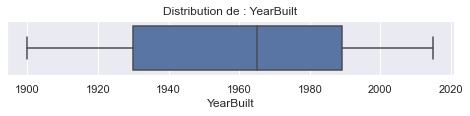

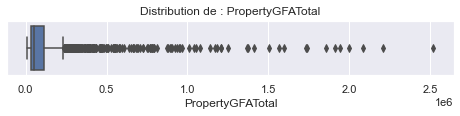

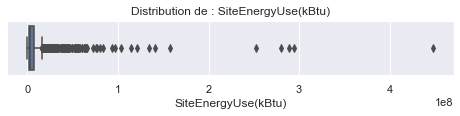

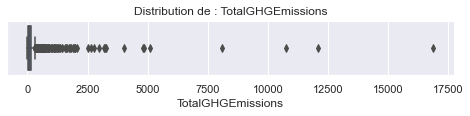

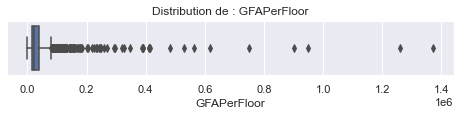

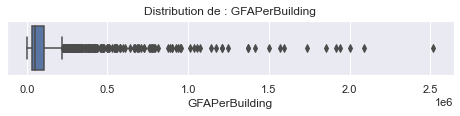

In [11]:
###################################################################################################
####################       Recherche d'erreurs et de valeurs aberrantes         ###################
###################################################################################################

#ERROR : CHINESE BAPTIST CHURCH don't have 99 floors but only 2
df.loc[df.index[df['NumberofFloors']==99],'NumberofFloors'] = 2
GFAPerFloor = round((df.loc[df.index[df['NumberofFloors']==99], 'PropertyGFATotal'] / 2),2)
df.loc[df.index[df['NumberofFloors']==99],'GFAPerFloor'] = GFAPerFloor

#valeur outlier : row 3330 l'université de washington 111 bâtiments différents,
#une années de construction trouble ( 1861 selon wiki, 1900 selon le dataset)
df.drop(df.index[df["NumberofBuildings"]==111], inplace=True)
df.to_csv('Data/Clean_data.csv', index_label=False)  


import seaborn as sns
import matplotlib.pyplot as plt
            
var_to_hist = ['YearBuilt','PropertyGFATotal','SiteEnergyUse(kBtu)',
               'TotalGHGEmissions', 'GFAPerFloor', 'GFAPerBuilding']         
#df = df.loc[df['PropertyGFATotal']<1500000]
for column in var_to_hist:
    plt.figure(figsize = (8,1))
    
    sns.boxplot(x=df[column])
    chaine = 'Distribution de : ' + column
    plt.title(chaine)
    plt.xlabel(column)
    plt.show()
sns.set(font_scale=1)


#### Nettoyage des données :

##### Supprimer les doublons:
 
 **Supprimer les doublons de bâtiments** et choisir quelles valeurs conserver
 
 **Supprimer les individus sans informations** s'ils existent
 
 **Rechercher les valeurs aberrantes et les corriger**
 
 **Traiter les valeurs NaN**

Nous allons regrouper les données d'identification des bâtiments afin qu'elles ne perturbent pas nos modélisations mais restent utilisables.

identification_features = ['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode']
data_identification = data[identification_features]
data.drop(identification_features, axis=1, inplace = True)


Le but de notre programme est de supprimer les relevés couteux pour les années à venir. Nous allons donc exclure toutes les données de relève de notre dataset.

In [10]:
#Doublons
df.drop_duplicates(subset=['OSEBuildingID'], inplace=True)
list_doublons = []
for i, row in df.T.items():
    if i not in big_set :
        big_set = set()
        address = row['Address']
        Bldg_ID = row['OSEBuildingID']
        Owner_ID = row['TaxParcelIdentificationNumber']
        name = row['PropertyName']
        lat = row['Latitude']
        long = row['Longitude']
        same_loc = df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long) & (df['TaxParcelIdentificationNumber'] == Owner_ID)]# & (df['Address'] == address)]
        if same_loc.shape[0] > 1 :
            big_set.update(same_loc.index.values)
        if len(list_doublons) == 0 and len(big_set) != 0 :
            list_doublons.append(big_set)
        else :
            for x in list_doublons.copy():
                if big_set.intersection(x):
                    #if some elements are intercorrelated, merge the group
                    list_doublons[list_doublons.index(x)] = set.union(x, big_set)
                    big_set = set() # avoid adding duplicate
                    break
            if len(big_set) != 0 :
                # add a new correlated group only if no intersection 
                list_doublons.append(big_set)

for doubles in list_doublons:
    for id_d in list(doubles):
        print(df.loc[id_d,'PropertyName'], " and ", df.loc[id_d,'DataYear'])
    print('\n')

NameError: name 'big_set' is not defined